**Stage1 results**


=== Validation (last) ===
mAP@0.50: 0.9326
mAP@0.50:0.95: 0.8493
Precision: 0.9489
Recall: 0.9050

=== Loss (last) ===
Train total: 2.4214
  - box_loss: 0.7288
  - cls_loss: 0.4486
  - dfl_loss: 1.2440
Val total: 2.8115
  - box_loss: 0.8372
  - cls_loss: 0.4970
  - dfl_loss: 1.4773

=== CSV scan ===
Best mAP@0.50: 0.9327 (epoch 73)
10-epoch trend Δ: +0.0005
Status: balanced


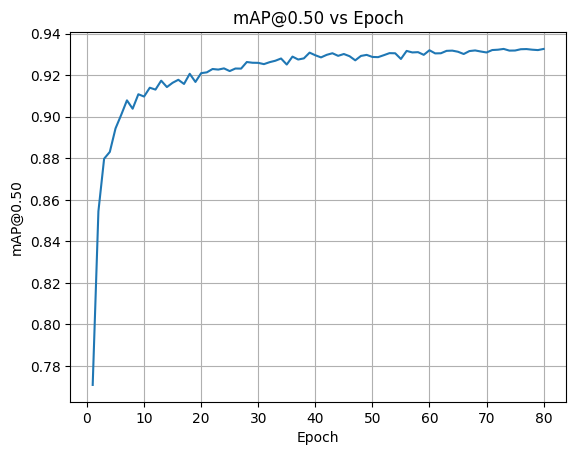

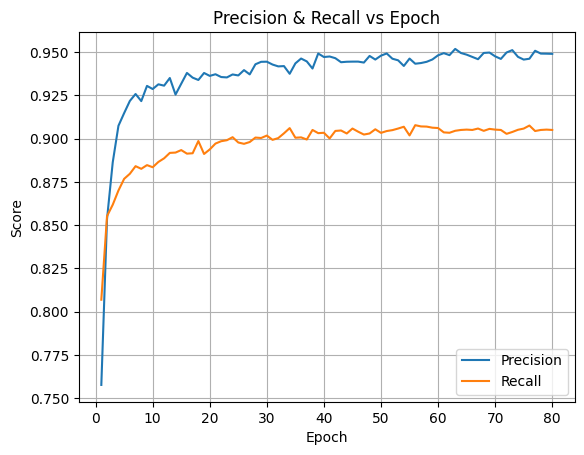

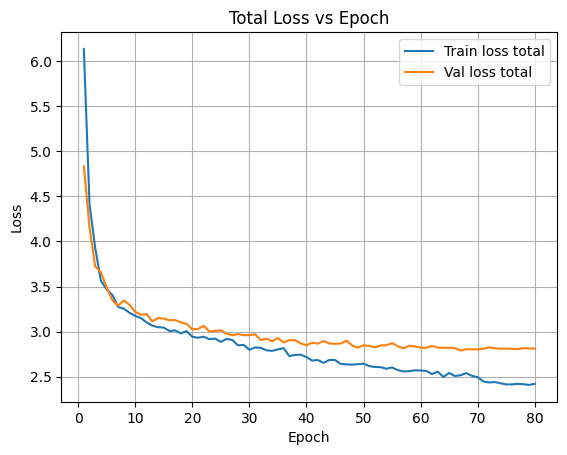

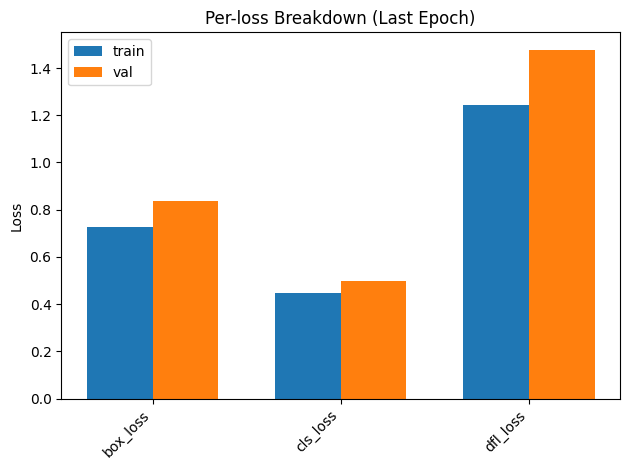

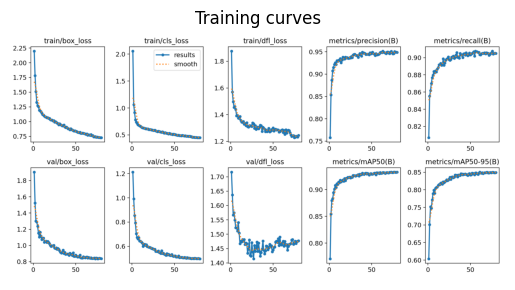

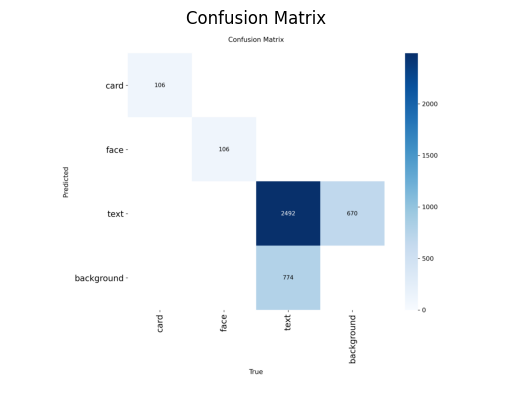

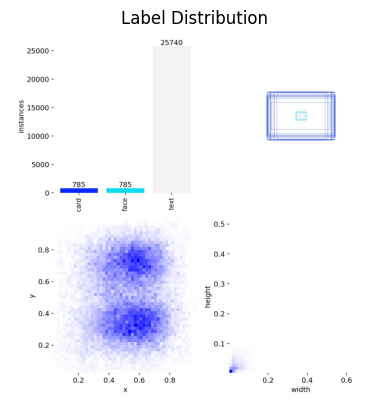

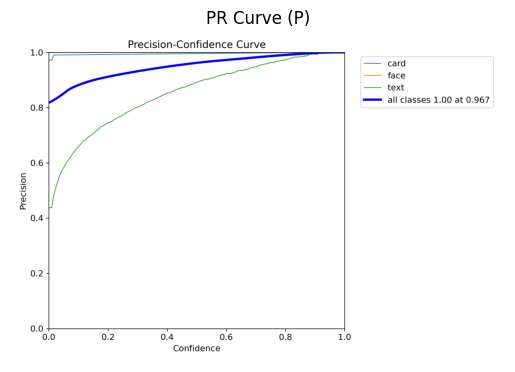

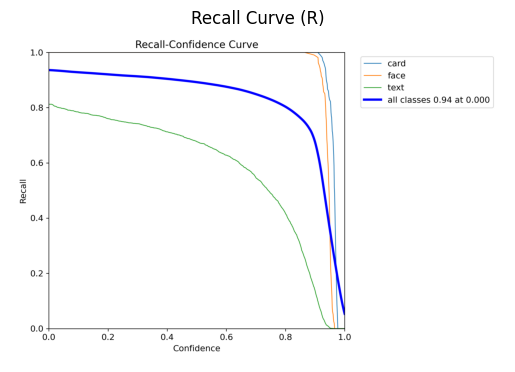

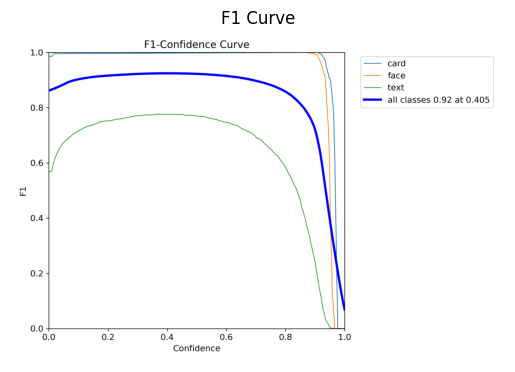

In [9]:
from pathlib import Path
import csv, numpy as np
import matplotlib.pyplot as plt

RUN_DIR = Path("/Users/shatha/Desktop/privacy-blurring-system/models/model/obb_fixed_v14")
p = RUN_DIR / "results.csv"
if not p.exists(): raise FileNotFoundError(p)

rows = list(csv.DictReader(open(p, newline=""))); last = rows[-1]
ff = lambda x: (float(x) if x is not None and str(x).strip() not in ("","nan") else None)
pick = lambda r, ks, d=0.0: next((v for k in ks if (v:=ff(r.get(k))) is not None), d)
kP,kR,k50,k95 = ["metrics/precision(B)","metrics/precision"],["metrics/recall(B)","metrics/recall"],["metrics/mAP50(B)","metrics/mAP50"],["metrics/mAP50-95(B)","metrics/mAP50-95"]
mP,mR,m50,m5095 = pick(last,kP),pick(last,kR),pick(last,k50),pick(last,k95)

tl = {k.split("train/")[1]:ff(v) for k,v in last.items() if k.startswith("train/") and "loss" in k and ff(v) is not None}
vl = {k.split("val/")[1]:ff(v)   for k,v in last.items() if k.startswith("val/")   and "loss" in k and ff(v) is not None}
tlt,vlt = (sum(tl.values()) if tl else 0.0),(sum(vl.values()) if vl else 0.0)

metric = lambda r: pick(r,k50,0.0)
best_m,best_e = -1.0,-1
for r in rows:
    m = metric(r)
    if m>best_m: best_m,best_e = m, int(ff(r.get("epoch")) or -1)

tail = rows[-min(10,len(rows)):]
trend = (metric(tail[-1]) - metric(tail[0])) if len(tail)>=2 else 0.0
status = "underfitting" if (m50 or 0.0) < 0.30 else ("possible overfitting" if trend<-0.02 and tlt<vlt else "balanced")

print("=== Validation (last) ===")
print(f"mAP@0.50: {m50:.4f}\nmAP@0.50:0.95: {m5095:.4f}\nPrecision: {mP:.4f}\nRecall: {mR:.4f}")
print("\n=== Loss (last) ===")
print(f"Train total: {tlt:.4f}"); [print(f"  - {k}: {tl[k]:.4f}") for k in sorted(tl)]
print(f"Val total: {vlt:.4f}");   [print(f"  - {k}: {vl[k]:.4f}") for k in sorted(vl)]
print("\n=== CSV scan ===")
print(f"Best mAP@0.50: {best_m:.4f} (epoch {best_e})\n10-epoch trend Δ: {trend:+.4f}\nStatus: {status}")

epochs = [int(ff(r.get("epoch")) or i) for i,r in enumerate(rows)]
prec  = [pick(r,kP,0.0)  for r in rows]
rec   = [pick(r,kR,0.0)  for r in rows]
map50 = [metric(r)       for r in rows]
def sum_losses(prefix):
    out=[]
    for r in rows:
        s=0.0
        for k,v in r.items():
            if k.startswith(prefix) and "loss" in k and ff(v) is not None: s+=ff(v)
        out.append(s)
    return out
tr_loss, va_loss = sum_losses("train/"), sum_losses("val/")

plt.figure(); plt.plot(epochs,map50); plt.title("mAP@0.50 vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("mAP@0.50"); plt.grid(True); plt.show()
plt.figure(); 
plt.plot(epochs,prec,label="Precision"); plt.plot(epochs,rec,label="Recall"); 
plt.title("Precision & Recall vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend(); plt.grid(True); plt.show()
plt.figure(); 
plt.plot(epochs,tr_loss,label="Train loss total"); plt.plot(epochs,va_loss,label="Val loss total")
plt.title("Total Loss vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

if tl or vl:
    import itertools
    keys = sorted(set(itertools.chain(tl.keys(),vl.keys())))
    x = np.arange(len(keys)); w=0.35
    plt.figure(); 
    plt.bar(x-w/2,[tl.get(k,0.0) for k in keys],width=w,label="train")
    plt.bar(x+w/2,[vl.get(k,0.0) for k in keys],width=w,label="val")
    plt.title("Per-loss Breakdown (Last Epoch)"); plt.xticks(x,keys,rotation=45,ha="right"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

for name,title in [("results.png","Training curves"),("confusion_matrix.png","Confusion Matrix"),("labels.jpg","Label Distribution"),("BoxP_curve.png","PR Curve (P)"),("BoxR_curve.png","Recall Curve (R)"),("BoxF1_curve.png","F1 Curve")]:
    q = RUN_DIR / name
    if q.exists():
        import matplotlib.image as mpimg
        img = mpimg.imread(q)
        plt.figure(); plt.imshow(img); plt.title(title); plt.axis("off"); plt.show()


Found 1 image(s)


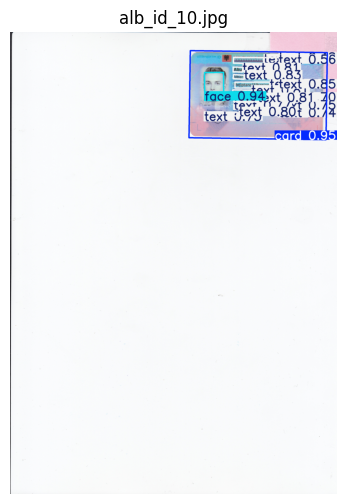

alb_id_10.jpg -> classes: []


In [10]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

BEST_PT = "/Users/shatha/Desktop/privacy-blurring-system/models/model/obb_fixed_v14/weights/best.pt"
SOURCE  = "/Users/shatha/Desktop/privacy-blurring-system/final_data/test/images/alb_id_10.jpg"

model = YOLO(BEST_PT)

p = Path(SOURCE)
exts = {".jpg", ".jpeg", ".png"}
images = [p] if p.is_file() and p.suffix.lower() in exts else [q for q in p.rglob("*") if q.suffix.lower() in exts]

if not images:
    raise FileNotFoundError(f"No images found under: {SOURCE}")

print(f"Found {len(images)} image(s)")
for img_path in images[:5]:
    res = model.predict(source=str(img_path), imgsz=960, conf=0.25, iou=0.5, verbose=False)[0]
    plotted = res.plot()
    plt.figure(figsize=(8,6)); plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(img_path.name); plt.show()
    print(f"{img_path.name} -> classes:", res.boxes.cls.tolist() if res.boxes is not None else [])


Found 1 image(s)


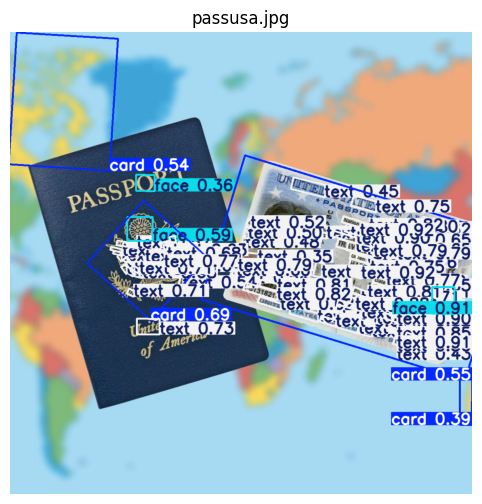

passusa.jpg -> classes: []


In [15]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

BEST_PT = "/Users/shatha/Desktop/privacy-blurring-system/models/model/obb_fixed_v14/weights/best.pt"
SOURCE  = "/Users/shatha/Desktop/privacy-blurring-system/final_data/passusa.jpg"

model = YOLO(BEST_PT)

p = Path(SOURCE)
exts = {".jpg", ".jpeg", ".png"}
images = [p] if p.is_file() and p.suffix.lower() in exts else [q for q in p.rglob("*") if q.suffix.lower() in exts]

if not images:
    raise FileNotFoundError(f"No images found under: {SOURCE}")

print(f"Found {len(images)} image(s)")
for img_path in images[:5]:
    res = model.predict(source=str(img_path), imgsz=960, conf=0.25, iou=0.5, verbose=False)[0]
    plotted = res.plot()
    plt.figure(figsize=(8,6)); plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(img_path.name); plt.show()
    print(f"{img_path.name} -> classes:", res.boxes.cls.tolist() if res.boxes is not None else [])


**Stage2 results**

=== Validation (last) ===
mAP@0.50: 0.9455
mAP@0.50:0.95: 0.8630
Precision: 0.9398
Recall: 0.9243

=== Loss (last) ===
Train total: 2.8255
  - box_loss: 0.8515
  - cls_loss: 0.5609
  - dfl_loss: 1.4131
Val total: 2.9684
  - box_loss: 0.9461
  - cls_loss: 0.6014
  - dfl_loss: 1.4210

=== CSV scan ===
Best mAP@0.50: 0.9486 (epoch 20)
10-epoch trend Δ: -0.0008
Status: balanced


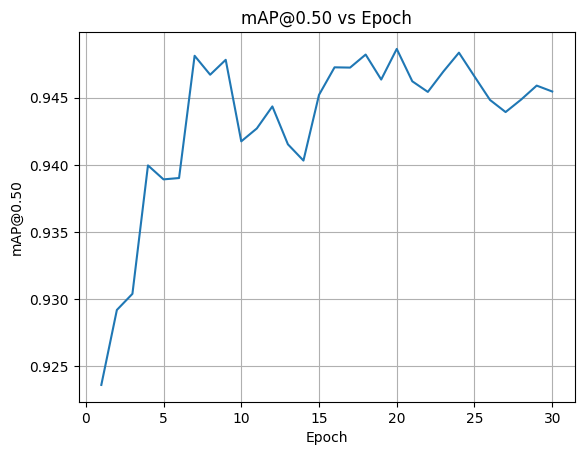

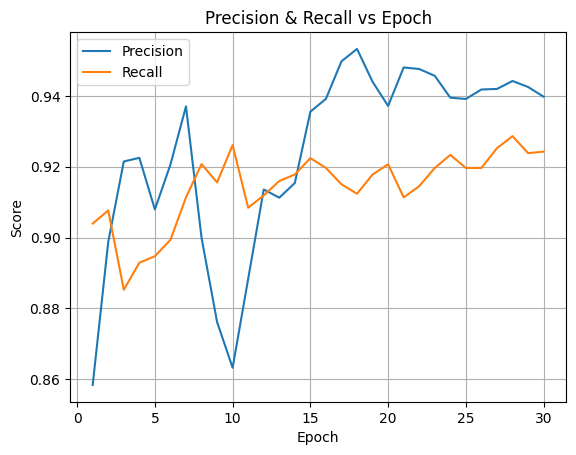

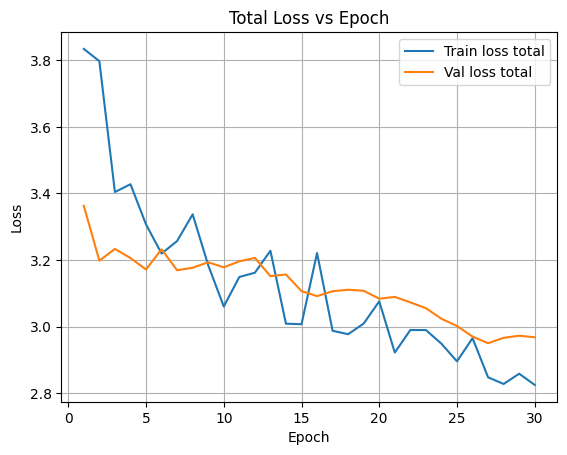

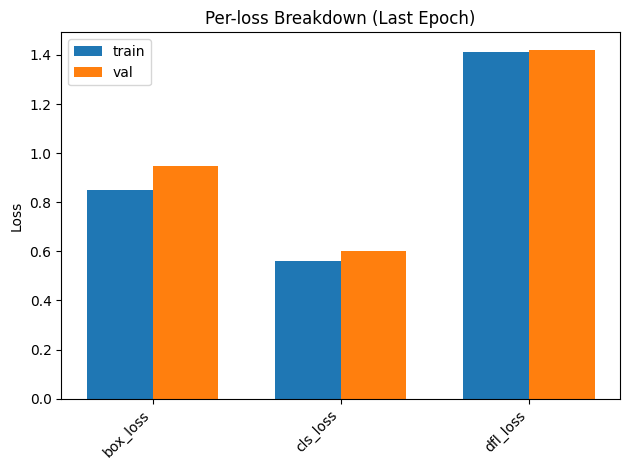

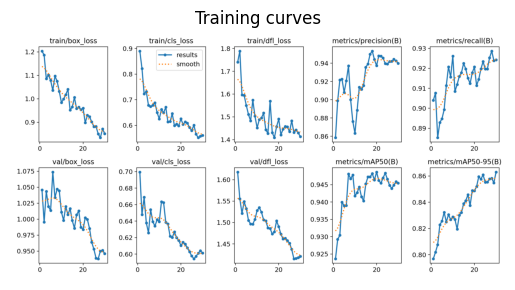

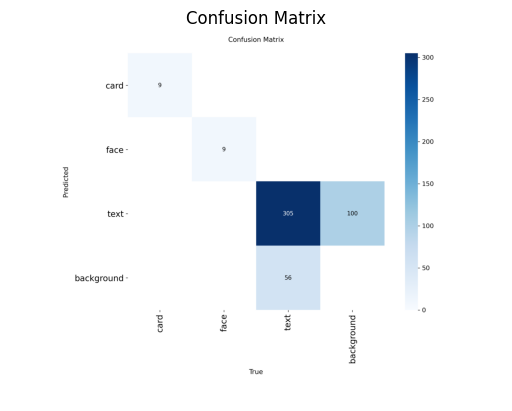

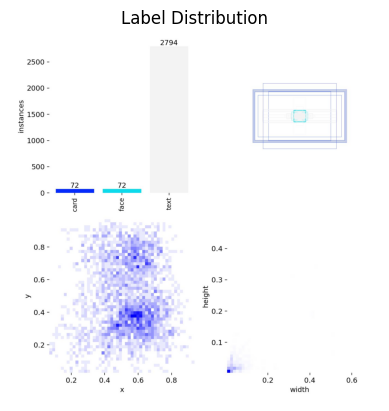

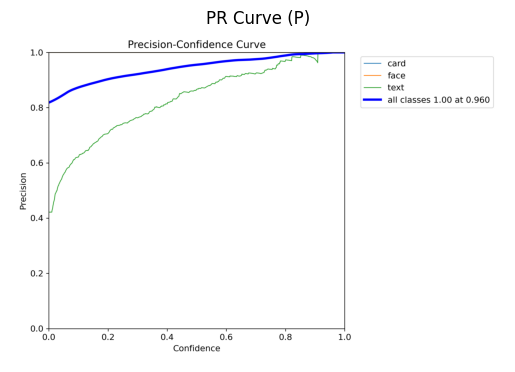

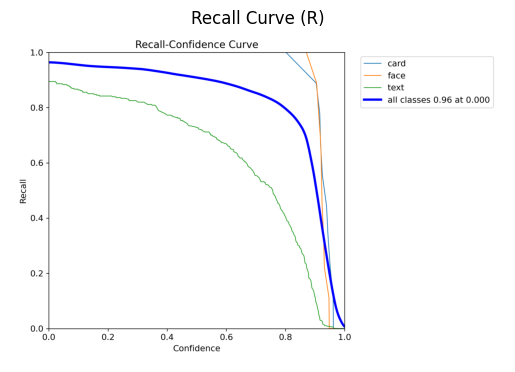

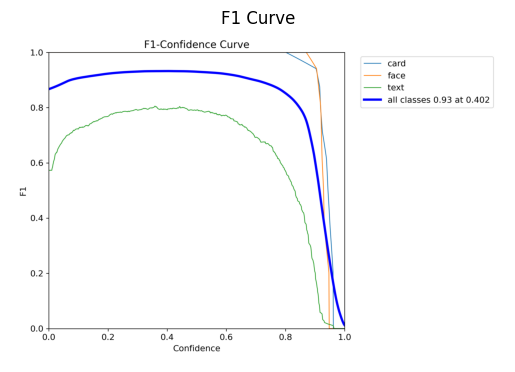

In [2]:
from pathlib import Path
import csv, numpy as np
import matplotlib.pyplot as plt

RUN_DIR = Path("/Users/shatha/Desktop/privacy-blurring-system/models/model/BG_v14")
p = RUN_DIR / "results.csv"
if not p.exists(): raise FileNotFoundError(p)

rows = list(csv.DictReader(open(p, newline=""))); last = rows[-1]
ff = lambda x: (float(x) if x is not None and str(x).strip() not in ("","nan") else None)
pick = lambda r, ks, d=0.0: next((v for k in ks if (v:=ff(r.get(k))) is not None), d)
kP,kR,k50,k95 = ["metrics/precision(B)","metrics/precision"],["metrics/recall(B)","metrics/recall"],["metrics/mAP50(B)","metrics/mAP50"],["metrics/mAP50-95(B)","metrics/mAP50-95"]
mP,mR,m50,m5095 = pick(last,kP),pick(last,kR),pick(last,k50),pick(last,k95)

tl = {k.split("train/")[1]:ff(v) for k,v in last.items() if k.startswith("train/") and "loss" in k and ff(v) is not None}
vl = {k.split("val/")[1]:ff(v)   for k,v in last.items() if k.startswith("val/")   and "loss" in k and ff(v) is not None}
tlt,vlt = (sum(tl.values()) if tl else 0.0),(sum(vl.values()) if vl else 0.0)

metric = lambda r: pick(r,k50,0.0)
best_m,best_e = -1.0,-1
for r in rows:
    m = metric(r)
    if m>best_m: best_m,best_e = m, int(ff(r.get("epoch")) or -1)

tail = rows[-min(10,len(rows)):]
trend = (metric(tail[-1]) - metric(tail[0])) if len(tail)>=2 else 0.0
status = "underfitting" if (m50 or 0.0) < 0.30 else ("possible overfitting" if trend<-0.02 and tlt<vlt else "balanced")

print("=== Validation (last) ===")
print(f"mAP@0.50: {m50:.4f}\nmAP@0.50:0.95: {m5095:.4f}\nPrecision: {mP:.4f}\nRecall: {mR:.4f}")
print("\n=== Loss (last) ===")
print(f"Train total: {tlt:.4f}"); [print(f"  - {k}: {tl[k]:.4f}") for k in sorted(tl)]
print(f"Val total: {vlt:.4f}");   [print(f"  - {k}: {vl[k]:.4f}") for k in sorted(vl)]
print("\n=== CSV scan ===")
print(f"Best mAP@0.50: {best_m:.4f} (epoch {best_e})\n10-epoch trend Δ: {trend:+.4f}\nStatus: {status}")

epochs = [int(ff(r.get("epoch")) or i) for i,r in enumerate(rows)]
prec  = [pick(r,kP,0.0)  for r in rows]
rec   = [pick(r,kR,0.0)  for r in rows]
map50 = [metric(r)       for r in rows]
def sum_losses(prefix):
    out=[]
    for r in rows:
        s=0.0
        for k,v in r.items():
            if k.startswith(prefix) and "loss" in k and ff(v) is not None: s+=ff(v)
        out.append(s)
    return out
tr_loss, va_loss = sum_losses("train/"), sum_losses("val/")

plt.figure(); plt.plot(epochs,map50); plt.title("mAP@0.50 vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("mAP@0.50"); plt.grid(True); plt.show()
plt.figure(); 
plt.plot(epochs,prec,label="Precision"); plt.plot(epochs,rec,label="Recall"); 
plt.title("Precision & Recall vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend(); plt.grid(True); plt.show()
plt.figure(); 
plt.plot(epochs,tr_loss,label="Train loss total"); plt.plot(epochs,va_loss,label="Val loss total")
plt.title("Total Loss vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

if tl or vl:
    import itertools
    keys = sorted(set(itertools.chain(tl.keys(),vl.keys())))
    x = np.arange(len(keys)); w=0.35
    plt.figure(); 
    plt.bar(x-w/2,[tl.get(k,0.0) for k in keys],width=w,label="train")
    plt.bar(x+w/2,[vl.get(k,0.0) for k in keys],width=w,label="val")
    plt.title("Per-loss Breakdown (Last Epoch)"); plt.xticks(x,keys,rotation=45,ha="right"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

for name,title in [("results.png","Training curves"),("confusion_matrix.png","Confusion Matrix"),("labels.jpg","Label Distribution"),("BoxP_curve.png","PR Curve (P)"),("BoxR_curve.png","Recall Curve (R)"),("BoxF1_curve.png","F1 Curve")]:
    q = RUN_DIR / name
    if q.exists():
        import matplotlib.image as mpimg
        img = mpimg.imread(q)
        plt.figure(); plt.imshow(img); plt.title(title); plt.axis("off"); plt.show()


Found 1 image(s)


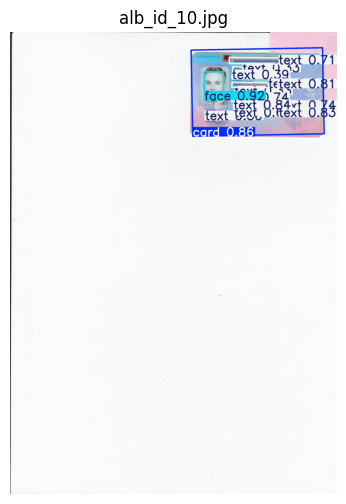

alb_id_10.jpg -> classes: []


In [4]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

BEST_PT = "/Users/shatha/Desktop/privacy-blurring-system/models/model/BG_v14/weights/best.pt"
SOURCE  = "/Users/shatha/Desktop/privacy-blurring-system/final_data/test/images/alb_id_10.jpg"

model = YOLO(BEST_PT)

p = Path(SOURCE)
exts = {".jpg", ".jpeg", ".png"}
images = [p] if p.is_file() and p.suffix.lower() in exts else [q for q in p.rglob("*") if q.suffix.lower() in exts]

if not images:
    raise FileNotFoundError(f"No images found under: {SOURCE}")

print(f"Found {len(images)} image(s)")
for img_path in images[:5]:
    res = model.predict(source=str(img_path), imgsz=960, conf=0.25, iou=0.5, verbose=False)[0]
    plotted = res.plot()
    plt.figure(figsize=(8,6)); plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(img_path.name); plt.show()
    print(f"{img_path.name} -> classes:", res.boxes.cls.tolist() if res.boxes is not None else [])


Found 1 image(s)


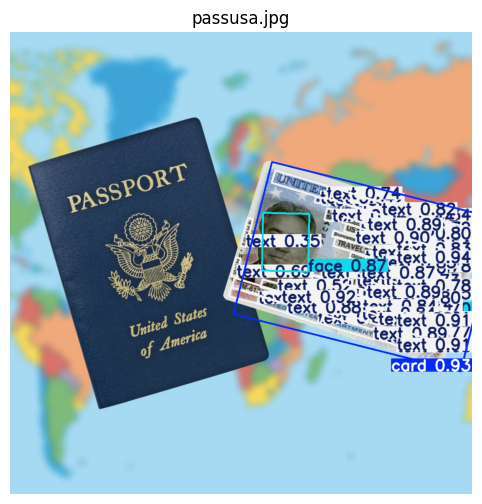

passusa.jpg -> classes: []


In [5]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

BEST_PT = "/Users/shatha/Desktop/privacy-blurring-system/models/model/BG_v14/weights/best.pt"
SOURCE  = "/Users/shatha/Desktop/privacy-blurring-system/final_data/passusa.jpg"

model = YOLO(BEST_PT)

p = Path(SOURCE)
exts = {".jpg", ".jpeg", ".png"}
images = [p] if p.is_file() and p.suffix.lower() in exts else [q for q in p.rglob("*") if q.suffix.lower() in exts]

if not images:
    raise FileNotFoundError(f"No images found under: {SOURCE}")

print(f"Found {len(images)} image(s)")
for img_path in images[:5]:
    res = model.predict(source=str(img_path), imgsz=960, conf=0.25, iou=0.5, verbose=False)[0]
    plotted = res.plot()
    plt.figure(figsize=(8,6)); plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(img_path.name); plt.show()
    print(f"{img_path.name} -> classes:", res.boxes.cls.tolist() if res.boxes is not None else [])


**Stage3 results**

=== Validation (last) ===
mAP@0.50: 0.9660
mAP@0.50:0.95: 0.9219
Precision: 0.9802
Recall: 0.9546

=== Loss (last) ===
Train total: 2.7621
  - box_loss: 0.8587
  - cls_loss: 0.5437
  - dfl_loss: 1.3597
Val total: 2.1499
  - box_loss: 0.6099
  - cls_loss: 0.4353
  - dfl_loss: 1.1046

=== CSV scan ===
Best mAP@0.50: 0.9687 (epoch 4)
10-epoch trend Δ: -0.0023
Status: balanced


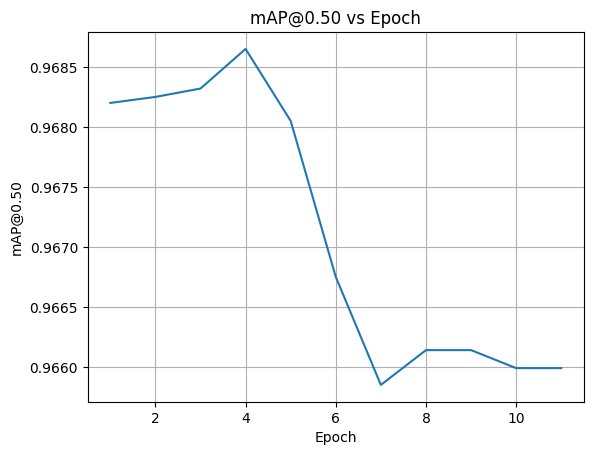

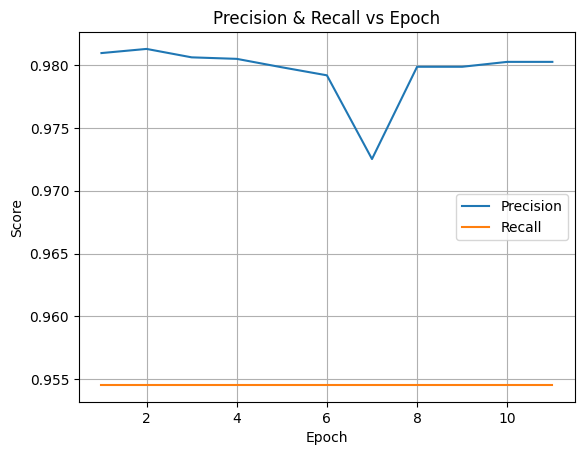

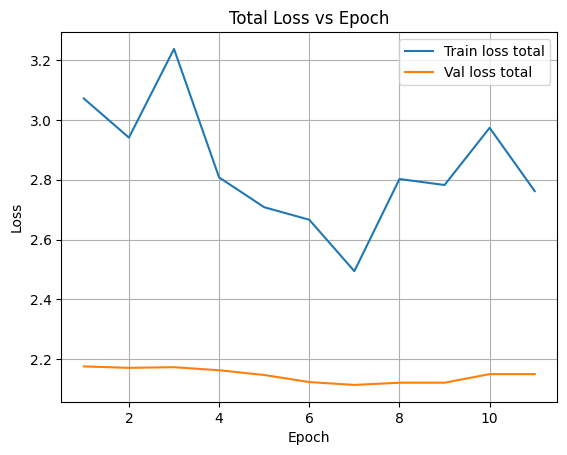

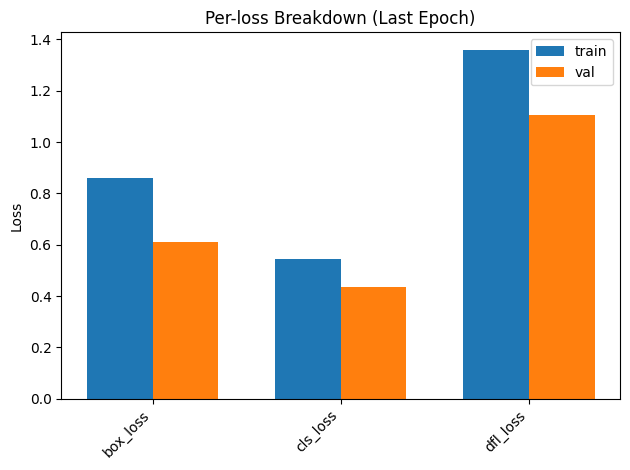

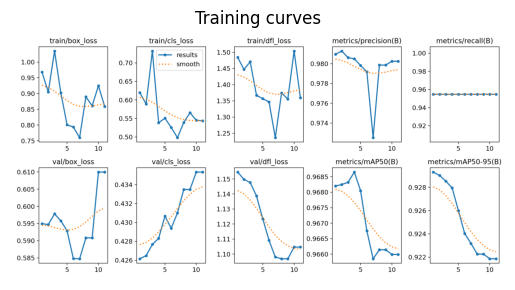

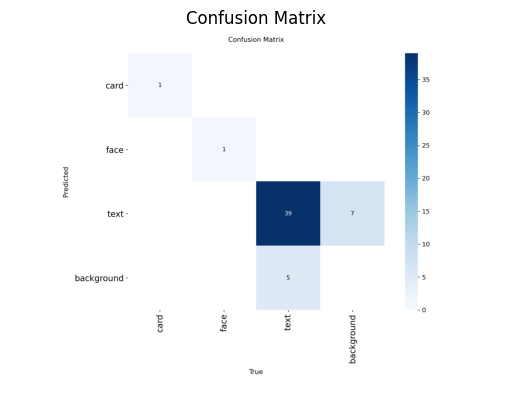

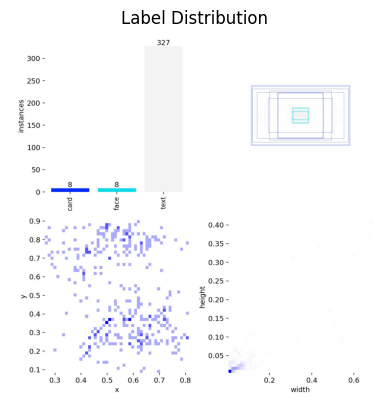

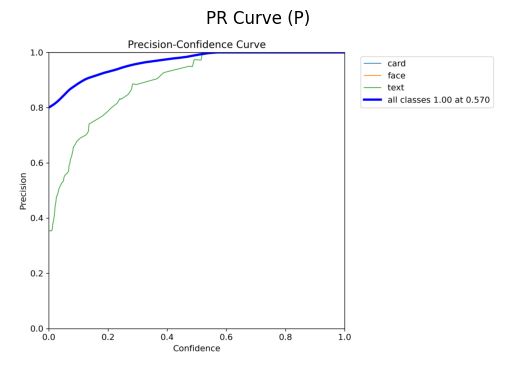

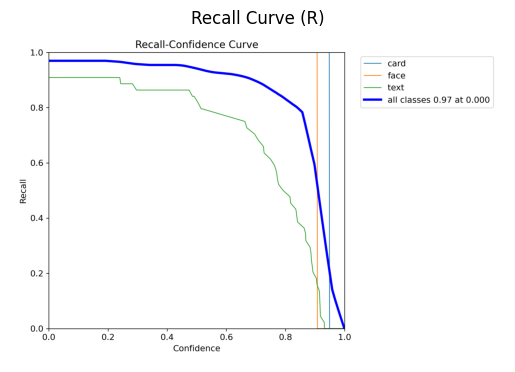

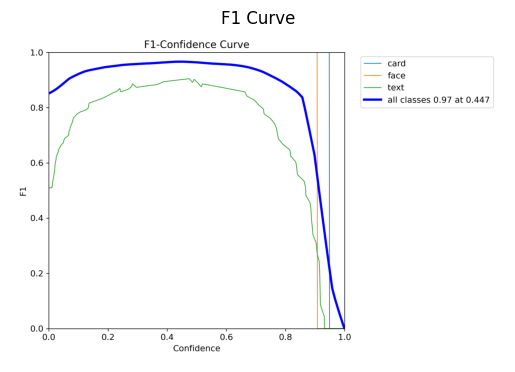

In [12]:
from pathlib import Path
import csv, numpy as np
import matplotlib.pyplot as plt

RUN_DIR = Path("/Users/shatha/Desktop/privacy-blurring-system/models/yolo_model")
p = RUN_DIR / "results.csv"
if not p.exists(): raise FileNotFoundError(p)

rows = list(csv.DictReader(open(p, newline=""))); last = rows[-1]
ff = lambda x: (float(x) if x is not None and str(x).strip() not in ("","nan") else None)
pick = lambda r, ks, d=0.0: next((v for k in ks if (v:=ff(r.get(k))) is not None), d)
kP,kR,k50,k95 = ["metrics/precision(B)","metrics/precision"],["metrics/recall(B)","metrics/recall"],["metrics/mAP50(B)","metrics/mAP50"],["metrics/mAP50-95(B)","metrics/mAP50-95"]
mP,mR,m50,m5095 = pick(last,kP),pick(last,kR),pick(last,k50),pick(last,k95)

tl = {k.split("train/")[1]:ff(v) for k,v in last.items() if k.startswith("train/") and "loss" in k and ff(v) is not None}
vl = {k.split("val/")[1]:ff(v)   for k,v in last.items() if k.startswith("val/")   and "loss" in k and ff(v) is not None}
tlt,vlt = (sum(tl.values()) if tl else 0.0),(sum(vl.values()) if vl else 0.0)

metric = lambda r: pick(r,k50,0.0)
best_m,best_e = -1.0,-1
for r in rows:
    m = metric(r)
    if m>best_m: best_m,best_e = m, int(ff(r.get("epoch")) or -1)

tail = rows[-min(10,len(rows)):]
trend = (metric(tail[-1]) - metric(tail[0])) if len(tail)>=2 else 0.0
status = "underfitting" if (m50 or 0.0) < 0.30 else ("possible overfitting" if trend<-0.02 and tlt<vlt else "balanced")

print("=== Validation (last) ===")
print(f"mAP@0.50: {m50:.4f}\nmAP@0.50:0.95: {m5095:.4f}\nPrecision: {mP:.4f}\nRecall: {mR:.4f}")
print("\n=== Loss (last) ===")
print(f"Train total: {tlt:.4f}"); [print(f"  - {k}: {tl[k]:.4f}") for k in sorted(tl)]
print(f"Val total: {vlt:.4f}");   [print(f"  - {k}: {vl[k]:.4f}") for k in sorted(vl)]
print("\n=== CSV scan ===")
print(f"Best mAP@0.50: {best_m:.4f} (epoch {best_e})\n10-epoch trend Δ: {trend:+.4f}\nStatus: {status}")

epochs = [int(ff(r.get("epoch")) or i) for i,r in enumerate(rows)]
prec  = [pick(r,kP,0.0)  for r in rows]
rec   = [pick(r,kR,0.0)  for r in rows]
map50 = [metric(r)       for r in rows]
def sum_losses(prefix):
    out=[]
    for r in rows:
        s=0.0
        for k,v in r.items():
            if k.startswith(prefix) and "loss" in k and ff(v) is not None: s+=ff(v)
        out.append(s)
    return out
tr_loss, va_loss = sum_losses("train/"), sum_losses("val/")

plt.figure(); plt.plot(epochs,map50); plt.title("mAP@0.50 vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("mAP@0.50"); plt.grid(True); plt.show()
plt.figure(); 
plt.plot(epochs,prec,label="Precision"); plt.plot(epochs,rec,label="Recall"); 
plt.title("Precision & Recall vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend(); plt.grid(True); plt.show()
plt.figure(); 
plt.plot(epochs,tr_loss,label="Train loss total"); plt.plot(epochs,va_loss,label="Val loss total")
plt.title("Total Loss vs Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.show()

if tl or vl:
    import itertools
    keys = sorted(set(itertools.chain(tl.keys(),vl.keys())))
    x = np.arange(len(keys)); w=0.35
    plt.figure(); 
    plt.bar(x-w/2,[tl.get(k,0.0) for k in keys],width=w,label="train")
    plt.bar(x+w/2,[vl.get(k,0.0) for k in keys],width=w,label="val")
    plt.title("Per-loss Breakdown (Last Epoch)"); plt.xticks(x,keys,rotation=45,ha="right"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

for name,title in [("results.png","Training curves"),("confusion_matrix.png","Confusion Matrix"),("labels.jpg","Label Distribution"),("BoxP_curve.png","PR Curve (P)"),("BoxR_curve.png","Recall Curve (R)"),("BoxF1_curve.png","F1 Curve")]:
    q = RUN_DIR / name
    if q.exists():
        import matplotlib.image as mpimg
        img = mpimg.imread(q)
        plt.figure(); plt.imshow(img); plt.title(title); plt.axis("off"); plt.show()


Found 1 image(s)


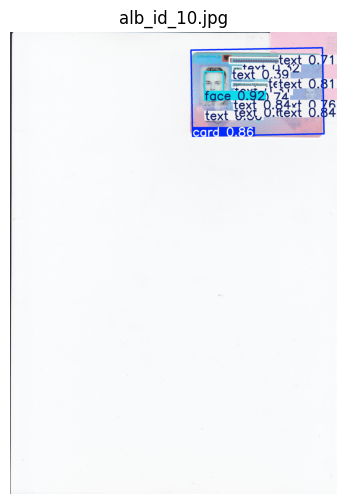

alb_id_10.jpg -> classes: []


In [13]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

BEST_PT = "/Users/shatha/Desktop/privacy-blurring-system/models/yolo_model/weights/best.pt"
SOURCE  = "/Users/shatha/Desktop/privacy-blurring-system/final_data/test/images/alb_id_10.jpg"

model = YOLO(BEST_PT)

p = Path(SOURCE)
exts = {".jpg", ".jpeg", ".png"}
images = [p] if p.is_file() and p.suffix.lower() in exts else [q for q in p.rglob("*") if q.suffix.lower() in exts]

if not images:
    raise FileNotFoundError(f"No images found under: {SOURCE}")

print(f"Found {len(images)} image(s)")
for img_path in images[:5]:
    res = model.predict(source=str(img_path), imgsz=960, conf=0.25, iou=0.5, verbose=False)[0]
    plotted = res.plot()
    plt.figure(figsize=(8,6)); plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(img_path.name); plt.show()
    print(f"{img_path.name} -> classes:", res.boxes.cls.tolist() if res.boxes is not None else [])


Found 1 image(s)


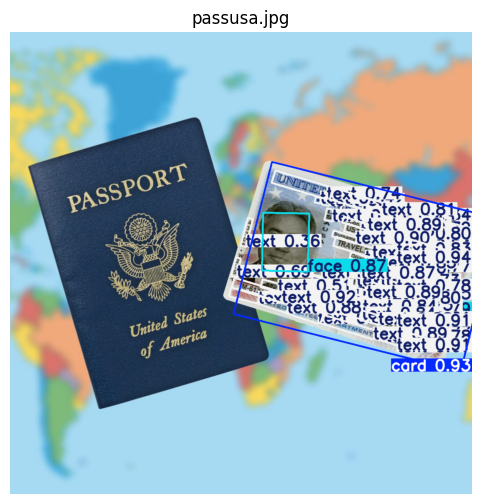

passusa.jpg -> classes: []


In [16]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

BEST_PT = "/Users/shatha/Desktop/privacy-blurring-system/models/yolo_model/weights/best.pt"
SOURCE  = "/Users/shatha/Desktop/privacy-blurring-system/final_data/passusa.jpg"

model = YOLO(BEST_PT)

p = Path(SOURCE)
exts = {".jpg", ".jpeg", ".png"}
images = [p] if p.is_file() and p.suffix.lower() in exts else [q for q in p.rglob("*") if q.suffix.lower() in exts]

if not images:
    raise FileNotFoundError(f"No images found under: {SOURCE}")

print(f"Found {len(images)} image(s)")
for img_path in images[:5]:
    res = model.predict(source=str(img_path), imgsz=960, conf=0.25, iou=0.5, verbose=False)[0]
    plotted = res.plot()
    plt.figure(figsize=(8,6)); plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title(img_path.name); plt.show()
    print(f"{img_path.name} -> classes:", res.boxes.cls.tolist() if res.boxes is not None else [])
